# DECEPTIVE REVIEW CLASSIFIER

In [311]:
!pip install nlpaug

In [312]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import re
pd.set_option('max_colwidth', 800)

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [313]:
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [314]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [315]:
#loading dataset
df=pd.read_csv('/content/deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [316]:
df.shape

(1600, 5)

In [317]:
df['deceptive'].value_counts()

deceptive    800
truthful     800
Name: deceptive, dtype: int64

In [318]:
df['polarity'].value_counts()

positive    800
negative    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [319]:
df['hotel'].value_counts()

hardrock            80
fairmont            80
palmer              80
hyatt               80
conrad              80
amalfi              80
monaco              80
talbott             80
allegro             80
hilton              80
affinia             80
swissotel           80
omni                80
sofitel             80
ambassador          80
knickerbocker       80
homewood            80
intercontinental    80
sheraton            80
james               80
Name: hotel, dtype: int64

In [320]:
df['source'].value_counts()

MTurk          800
TripAdvisor    400
Web            400
Name: source, dtype: int64

### DATA PREPROCESSING AND EDA

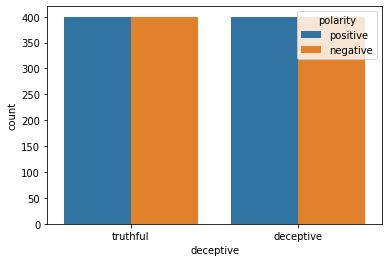

In [321]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

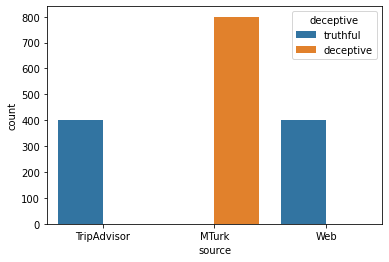

In [322]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [323]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [324]:
# so combining three text columns --- hotel, source, text
#df['text'] = df['hotel']+' '+df['source']+' '+df['text']
#df.head()

In [325]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [326]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [327]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [328]:
df['text'][1]

'Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n'

In [329]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [330]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

,deceptive,text,clean_text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n",We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n",Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h...",This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n",The Omni Chicago really delivers on all front

In [331]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [332]:
# renaming the column
df.rename(columns = {'clean_text':'text', 'deceptive' : 'label'}, inplace = True)
df.head()

,label,text
0,1,We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level of quality the Omni delivers Check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in Chicago Even the standard room has a separate living area and work desk The fitness center has free weights weight machines and two rows of cardio equipment I shared the room with others and did not feel cramped in any way All in all a great property
4,1,I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of service but when I did they were pleasant and prompt I used the fitness center which was well equipped and everything was in working order It is in a great location at one end of the Michigan Avenue shopping district


In [333]:
# preprocessing the data (removing stopwords, convert the sentence to lower case, and also applying lemmatization to get meaningful words )
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnl=WordNetLemmatizer()
def clean_text(review):
  review = review.lower()
  review = review.split()
  review = [wnl.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
  review = ' '.join(review)
  return review

In [334]:
df['text']=df['text'].apply(clean_text)
df.head()

,label,text
0,1,stayed one night getaway family thursday triple aaa rate steal th floor room complete plasma tv bose stereo voss evian water gorgeous bathroom concierge helpful cannot beat location flaw breakfast pricey service slow even though two table restaurant food good worth wait would return heartbeat gem chicago
1,1,triple rate upgrade view room le also included breakfast voucher great view river lake wrigley bldg tribune bldg major restaurant shopping sightseeing attraction within walking distance large room comfortable bed
2,1,come little late finally catching review past several month dear friend stayed hyatt regency late october one night visiting friend husband town hotel perfect imo easy check check lovely clean comfortable room great view city know area pretty well convenient many downtown chicago attraction dinner went clubing friend around division st problem getting cab back forth hyatt even public transportation right near bother since needed cab hotel parking usual chicago expensive able get car quickly problem best part got rate hotwire downright steal area chicago quality hotel
3,1,omni chicago really delivers front spaciousness room helpful staff prized location michigan avenue address chicago requires high level quality omni delivers check whole group people minute staff plentiful recommendation dining event room largest find price range chicago even standard room separate living area work desk fitness center free weight weight machine two row cardio equipment shared room others feel cramped way great property
4,1,asked high floor away elevator got room pleasantly decorated functional clean need whole lot service pleasant prompt used fitness center well equipped everything working order great location one end michigan avenue shopping district


### WORD VISUALIZATION

In [335]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [336]:
#making worldcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'until', 'doesn', 'd', 'these', "isn't", 'about', 'yourself', "mightn't", "shan't", 's', 'him', "it's", 'off', 'once', 'herself', 'won', 'any', 'ourselves', 'those', 'the', 'your', "should've", 'should', 'wouldn', 'some', 'had', 'no', 'an', 'it', 'having', 'to', 'same', 'ma', 'theirs', 'they', 'under', 'what', 'all', "wouldn't", 'other', 'own', 'she', 'before', 'on', "needn't", "you're", "wasn't", 'more', 'again', 'm', 'which', 'a', 'why', "you'll", 'isn', 'too', 'that', "don't", 'has', 'whom', 'against', 'in', 'mightn', 'don', 'is', 'me', 'shouldn', 'now', 'am', 'up', 'hadn', 've', 'below', 'just', 'or', 'll', 'do', 'so', 'while', 'through', 'by', 'such', 'above', 'out', 'our', "she's", 'their', 'was', 'be', 'who', 'but', "aren't", 'itself', 'wasn', 'during', 'been', 'her', 'how', "doesn't", 'you', 'most', 'doing', 'hasn', 'not', "you'd", "haven't", 'over', 'at', 'himself', "didn't", 'each', 'there', 'both', 'as', 'i', 'than', 'them', "that'll", 'from', 'where', "couldn't", 'haven', 

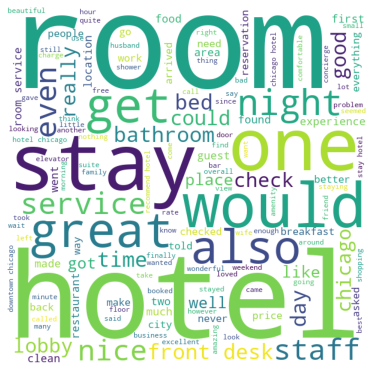

In [337]:
# visualizing the most frequent words using matplot library
comment_words = ' '
for words in df['text']: 
    comment_words = comment_words + words + ' '
    
wordcloud = WordCloud(width = 600, height = 600, 
                background_color='white' , 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### TRAIN - TEST SPLIT

In [338]:
df.head()

,label,text
0,1,stayed one night getaway family thursday triple aaa rate steal th floor room complete plasma tv bose stereo voss evian water gorgeous bathroom concierge helpful cannot beat location flaw breakfast pricey service slow even though two table restaurant food good worth wait would return heartbeat gem chicago
1,1,triple rate upgrade view room le also included breakfast voucher great view river lake wrigley bldg tribune bldg major restaurant shopping sightseeing attraction within walking distance large room comfortable bed
2,1,come little late finally catching review past several month dear friend stayed hyatt regency late october one night visiting friend husband town hotel perfect imo easy check check lovely clean comfortable room great view city know area pretty well convenient many downtown chicago attraction dinner went clubing friend around division st problem getting cab back forth hyatt even public transportation right near bother since needed cab hotel parking usual chicago expensive able get car quickly problem best part got rate hotwire downright steal area chicago quality hotel
3,1,omni chicago really delivers front spaciousness room helpful staff prized location michigan avenue address chicago requires high level quality omni delivers check whole group people minute staff plentiful recommendation dining event room largest find price range chicago even standard room separate living area work desk fitness center free weight weight machine two row cardio equipment shared room others feel cramped way great property
4,1,asked high floor away elevator got room pleasantly decorated functional clean need whole lot service pleasant prompt used fitness center well equipped everything working order great location one end michigan avenue shopping district


In [339]:
x = df['text']
y = df['label']

In [340]:
# train - test split equally splitting both 0 and 1.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y) 

In [341]:
X_test.head()

213                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       stayed night great hotel updated room clean used tim book theater dinning reservation provided excellent service close subway shopping dinning excellent value free wireless internet access nearby health club nice perk highly recommend future concern adjacent construction condo problem something ask front desk future
228                                                                                                                                                                                             

## TEXT AUGMENTATION USING SYNONYMS:

In [342]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=5)

In [343]:
sum(y_train==0)

640

In [344]:
sum(y_train==1)

640

In [345]:
naw.SynonymAug(aug_src='wordnet',aug_max=5).augment("The staff was very polite and helpfull and the rooms were very comfortable and felt like home.",n=10)

['The staff be very polite and helpfull and the room exist very well heeled and felt like home.',
 'The faculty was really polite and helpfull and the rooms be very comfortable and felt similar plate.',
 'The staff was really polite and helpfull and the rooms be very comfortable and feel like nursing home.',
 'The staff make up very civilised and helpfull and the rooms were really comfortable and felt similar home.',
 'The staff live very polite and helpfull and the rooms were rattling comfortable and felt like family.',
 'The staff was very civil and helpfull and the room were rattling prosperous and feel like home.',
 'The staff was real polite and helpfull and the rooms were rattling comfortable and felt like home.',
 'The staff was very civilized and helpfull and the rooms exist very comfortable and felt like home.',
 'The stave be very polite and helpfull and the rooms personify very prosperous and felt like home.',
 'The staff was very polite and helpfull and the room were very w

In [346]:
augmented_sentences=[]
augmented_sentences_labels=[]
for i in X_train.index:
  if y_train[i]==0:
    temps=aug.augment(X_train[i],n=10)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(0)
  else :
    temps=aug.augment(X_train[i],n=10)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(1)

In [347]:
# after augumenting, our dataset is multiplied with 10 times.
X_train=X_train.append(pd.Series(augmented_sentences),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels),ignore_index=True)

print(X_train.shape)
print(y_train.shape)

(14080,)
(14080,)


In [348]:
X_train

0                                                                                  oh goodness got one worst place stay downtown chicago went well enough checking went downhill much left desired biggest problem huge turd toilet kid guess maid rather busy day took break forgot know price charge type thing unacceptable everything else actual room expected noise bit used though convention college age kid staying floor u asked moved another room get u another room took nearly hour second room worked well u risking staying plus pool available really wish would mentioned website looking forward day beautiful place wonderful location need work customer service reconsider staying homewood suite hilton chicago downtown
1                                                                                                                                                                                                                                                                                       

In [349]:
y_train.value_counts()

1    7040
0    7040
dtype: int64

In [350]:
# checking the count of  y_test value 
y_test.value_counts()

1    160
0    160
Name: label, dtype: int64

In [351]:
# combining both train and test data 
# train data - 14080
# test data - 320
x=X_train.append(X_test).reset_index(drop=True)
y=y_train.append(y_test).reset_index(drop=True)

x.shape, y.shape

((14400,), (14400,))

### WORD EMBEDDINGS - WORD2VEC

In [352]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tokenizer

RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)

In [353]:
#Converting X_train to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in x.values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [354]:
X

[['oh',
  'goodness',
  'got',
  'one',
  'worst',
  'place',
  'stay',
  'downtown',
  'chicago',
  'went',
  'well',
  'enough',
  'checking',
  'went',
  'downhill',
  'much',
  'left',
  'desired',
  'biggest',
  'problem',
  'huge',
  'turd',
  'toilet',
  'kid',
  'guess',
  'maid',
  'rather',
  'busy',
  'day',
  'took',
  'break',
  'forgot',
  'know',
  'price',
  'charge',
  'type',
  'thing',
  'unacceptable',
  'everything',
  'else',
  'actual',
  'room',
  'expected',
  'noise',
  'bit',
  'used',
  'though',
  'convention',
  'college',
  'age',
  'kid',
  'staying',
  'floor',
  'asked',
  'moved',
  'another',
  'room',
  'get',
  'another',
  'room',
  'took',
  'nearly',
  'hour',
  'second',
  'room',
  'worked',
  'well',
  'risking',
  'staying',
  'plus',
  'pool',
  'available',
  'really',
  'wish',
  'would',
  'mentioned',
  'website',
  'looking',
  'forward',
  'day',
  'beautiful',
  'place',
  'wonderful',
  'location',
  'need',
  'work',
  'customer',


In [355]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [356]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 10699 words by a 100dim vector.

12364

In [357]:
#see a sample vector for random word, lets say 'Trump'
w2v_model["hotel"]

array([-0.52270466,  0.10729931, -0.23781753, -0.05307894, -0.03937136,
       -0.17013954,  1.2556815 , -1.985694  , -0.697202  , -0.01220441,
        0.43058127, -1.0537115 ,  1.4234158 ,  1.005649  ,  1.346655  ,
        0.25077394, -0.9609761 , -0.8229607 , -1.6333126 , -0.96955675,
       -0.7713749 , -0.08316252, -0.5769514 , -0.53769505, -0.5771289 ,
       -0.9047167 , -0.7353332 ,  1.333543  , -0.3047183 , -0.5352921 ,
        1.2411283 ,  0.63355416,  0.8251773 , -1.2028497 ,  0.07562812,
        2.036012  ,  1.1583153 ,  0.42082253, -1.0842806 ,  0.6105498 ,
        1.0511935 , -0.539141  ,  0.29860318, -0.4502028 ,  0.53457195,
       -0.93884593, -0.6753977 ,  0.78534937,  0.9895252 ,  0.36776707,
        0.1342731 , -0.6053898 , -0.8746713 , -0.18462905, -0.11644951,
        1.239956  ,  0.51907384, -0.3687746 ,  0.35006908, -0.7809097 ,
       -0.6227496 , -1.4592366 , -0.69191974, -0.82064056, -0.28623962,
       -0.23767869,  1.6263995 , -0.3075288 , -0.38890877,  0.73

In [358]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it to lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [359]:
X[0][:20]

[670,
 1775,
 31,
 10,
 369,
 21,
 4,
 81,
 3,
 72,
 27,
 195,
 361,
 72,
 2057,
 50,
 141,
 1700,
 1939,
 110]

In [360]:
word_index = tokenizer.word_index
word_index

{'hotel': 1,
 'room': 2,
 'chicago': 3,
 'stay': 4,
 'would': 5,
 'great': 6,
 'service': 7,
 'staff': 8,
 'night': 9,
 'one': 10,
 'bed': 11,
 'stayed': 12,
 'time': 13,
 'get': 14,
 'desk': 15,
 'like': 16,
 'location': 17,
 'day': 18,
 'could': 19,
 'nice': 20,
 'place': 21,
 'even': 22,
 'good': 23,
 'clean': 24,
 'also': 25,
 'front': 26,
 'well': 27,
 'experience': 28,
 'back': 29,
 'bathroom': 30,
 'got': 31,
 'first': 32,
 'check': 33,
 'view': 34,
 'restaurant': 35,
 'next': 36,
 'go': 37,
 'way': 38,
 'really': 39,
 'friendly': 40,
 'business': 41,
 'made': 42,
 'comfortable': 43,
 'recommend': 44,
 'never': 45,
 'area': 46,
 'two': 47,
 'price': 48,
 'city': 49,
 'much': 50,
 'make': 51,
 'lobby': 52,
 'guest': 53,
 'staying': 54,
 'floor': 55,
 'suite': 56,
 'breakfast': 57,
 'reservation': 58,
 'food': 59,
 'weekend': 60,
 'hour': 61,
 'minute': 62,
 'called': 63,
 'bar': 64,
 'better': 65,
 'arrived': 66,
 'trip': 67,
 'definitely': 68,
 'say': 69,
 'everything': 70,
 'th

In [361]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break   

hotel -> 1
room -> 2
chicago -> 3
stay -> 4
would -> 5
great -> 6
service -> 7
staff -> 8
night -> 9
one -> 10


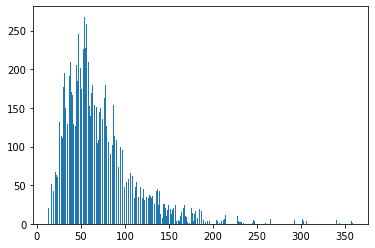

In [362]:
# For determining size of input...

# Making histogram for no of words in reviews shows that most reviews are under 150 words.
# Lets keep each news small and truncate all news to 150 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 150 words. Lets truncate these outliers :) 

In [363]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 250])
# Out of 14400 reviews, 14333 have less than 250 words

14333

In [364]:
#Lets keep all reviews to 250, add padding to news with less than 250 words and truncating long ones
maxlen = 250

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [365]:
X

array([[   0,    0,    0, ...,   83,    3,   81],
       [   0,    0,    0, ..., 7154, 5155, 1635],
       [   0,    0,    0, ...,  250,   65,    7],
       ...,
       [   0,    0,    0, ...,  127, 1137, 2154],
       [3203,  588,  507, ..., 2389,  575,  261],
       [   0,    0,    0, ..., 3254,  837, 3556]], dtype=int32)

In [366]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1
vocab_size

12365

In [367]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [368]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

## MODEL BUILDING USING LSTM

In [369]:
#Defining Neural Network
model=Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [370]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          1236500   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,278,805
Trainable params: 42,305
Non-trainable params: 1,236,500
_________________________________________________________________


In [371]:
# splitting the X data into train and test (which already mentioned the train test split)
# train data - 14080
# test data - 320
x_train = X[0:14080]

In [372]:
y_train = y[0:14080]

In [373]:
x_test = X[14080:]
y_test = y[14080:]

In [374]:
x_train.shape,y_train.shape

((14080, 250), (14080,))

In [375]:
y_train

0        0
1        1
2        0
3        0
4        1
        ..
14075    0
14076    0
14077    0
14078    0
14079    0
Length: 14080, dtype: int64

In [376]:
x_test.shape, y_test.shape

((320, 250), (320,))

In [377]:
x_test

array([[   0,    0,    0, ...,   26,   15,  598],
       [   0,    0,    0, ...,  500,  664,  183],
       [   0,    0,    2, ...,  167,    4,  642],
       ...,
       [   0,    0,    0, ...,  127, 1137, 2154],
       [3203,  588,  507, ..., 2389,  575,  261],
       [   0,    0,    0, ..., 3254,  837, 3556]], dtype=int32)

In [378]:
y_test.value_counts()

1    160
0    160
dtype: int64

In [379]:
x_train=np.asarray(x_train).astype(np.int)
y_train=np.asarray(y_train).astype(np.int)
x_test=np.asarray(x_test).astype(np.int)
y_test=np.asarray(y_test).astype(np.int)

In [380]:
model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=6)

Epoch 1/6
440/440 [==============================] - 120s 268ms/step - loss: 0.4867 - acc: 0.7562 - val_loss: 0.5339 - val_acc: 0.7750
Epoch 2/6
440/440 [==============================] - 118s 267ms/step - loss: 0.2644 - acc: 0.8920 - val_loss: 0.4766 - val_acc: 0.8062
Epoch 3/6
440/440 [==============================] - 118s 268ms/step - loss: 0.1641 - acc: 0.9359 - val_loss: 0.5179 - val_acc: 0.8125
Epoch 4/6
440/440 [==============================] - 118s 268ms/step - loss: 0.1032 - acc: 0.9637 - val_loss: 0.4877 - val_acc: 0.8438
Epoch 5/6
440/440 [==============================] - 118s 269ms/step - loss: 0.0835 - acc: 0.9716 - val_loss: 0.5468 - val_acc: 0.8531
Epoch 6/6
440/440 [==============================] - 118s 269ms/step - loss: 0.0588 - acc: 0.9800 - val_loss: 0.4909 - val_acc: 0.8594


Conclusion : After applying text augmentation for train split, the  LSTM model gives me 86% accuracy for the test dataset.

### MODEL EVALUATION

In [381]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=maxlen)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector
    if prediction>=0.5:
      return "true review"
    else:
      return "fake review"

In [382]:
text = "We stayed at the Conrad for 2 nights for a friends reunion. The room was clean and new feeling, nice city view, free bottled water in room upon arrival. Check in was a breeze, and our room was ready even though we were several hours early. All staff was friendly and helpful, excellent breakfast."
print(get_predictions(text))

true review


In [383]:
text = "For 250 dollars, cheapest room available at the Hard Rock Hotel Chicago, you would assume you would have access to wifi. Yet, that was not the case. I was told I 'could have had' internet if I had booked through the site, which I didnt. The lady in the reception had no idea what she was talking about and had to ask around about internet access in general."
print(get_predictions(text))

fake review


In [384]:
text = "The staff was very polite and helpfull and the rooms were very comfortable and felt like home."
print(get_predictions(text))

fake review


In [385]:
text = "I totally LOVED IT here!! When you called either the Front Desk or Room Service, the phone was answered with nice manner"
print(get_predictions(text))

true review


In [386]:
text ="Great Hotel, we always love breakfast in morning,and drinks in even when applicable. Around the corner from magnificent Mile,and close to lots of restaurants. Staff was great, we even checked in early before noon,and other room available less than hour later."
print(get_predictions(text))

true review


In [388]:
text ="bad hotel and aggressive staff"
print(get_predictions(text))

fake review
